In [139]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from scripts.data_utils import get_balanced_data
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.cm as cm

In [2]:
tweets,categories,sources = get_balanced_data(500)

In [3]:
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes
catCodes

0        2
1        2
2        2
3        2
4        2
        ..
7953    18
7954    18
7955    18
7956    18
7957    18
Length: 7958, dtype: int8

In [4]:
np.unique(categories)

array(['abusive', 'benevolent sexism', 'cyberbullying', 'derailing',
       'discredit', 'dominance', 'hateful', 'homophobic',
       'hostile sexism', 'insult', 'obscene', 'offensive', 'profane',
       'racist', 'sexual_harassment', 'spam', 'stereotype', 'threat',
       'vulgar'], dtype='<U17')

In [5]:
from collections import Counter
Counter(categories)

Counter({'cyberbullying': 355,
         'offensive': 500,
         'spam': 500,
         'abusive': 500,
         'hateful': 500,
         'profane': 500,
         'discredit': 500,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49,
         'obscene': 500,
         'insult': 500,
         'threat': 478,
         'racist': 500,
         'homophobic': 500,
         'benevolent sexism': 500,
         'hostile sexism': 500,
         'vulgar': 500})

In [6]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [7]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])

In [8]:
for i in range(len(tweets)):
    tweets[i] = str(tweets[i])

In [9]:
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [10]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(7958, 1209)

In [11]:
clusters = MiniBatchKMeans(n_clusters=19, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)
#clusters = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)

In [12]:
Counter(clusters)

Counter({2: 3322,
         11: 365,
         14: 411,
         15: 268,
         1: 604,
         16: 364,
         7: 234,
         9: 58,
         10: 474,
         3: 32,
         6: 250,
         8: 276,
         0: 188,
         5: 179,
         18: 21,
         12: 312,
         17: 208,
         4: 198,
         13: 194})

In [114]:
np.where(catCodes == 5)

(array([3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941,
        3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952,
        3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963,
        3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974,
        3975, 3976, 3977, 3978, 3979], dtype=int64),)

In [157]:
def plot_tsne(data, labels, defLabels=None, plotlabels=None):
    max_label = max(labels)
    #max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    pca = PCA(n_components=2, random_state=2).fit_transform(data.todense())
    tsne = TSNE(random_state=2).fit_transform(PCA(n_components=50, random_state=2).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]
    f, ax = plt.subplots(1, 1, figsize=(16, 7))
    pts2 = ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    #ax.set_title('TSNE Cluster Plot')

    # for each category, plot its annotation in centroid
    #if defLabels is not None:
    #    for ix in range(len(np.unique(labels))):
    #        if defLabels[ix] in plotlabels:
    #            ixs = np.where(labels == np.unique(labels)[ix])
    #            ax.annotate(defLabels[ix].upper(), alpha=1.0, xy=(np.median(tsne[ixs,0]), np.median(tsne[ixs,1])), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15)

    if defLabels is None:
        ax.legend(*pts2.legend_elements(num=None), loc='lower right')
    else:
        ax.legend(pts2.legend_elements(num=None)[0], defLabels, loc='lower right')

    return ax, f

In [13]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]


    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset, cmap="jet")
    #print(pts.legend_elements()[0])
    ax[0].set_title('PCA Cluster Plot')
    #print(*pts.legend_elements())
    #print(tsne[:, 0].shape)
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)

<ipython-input-158-5f4a40c699d8>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


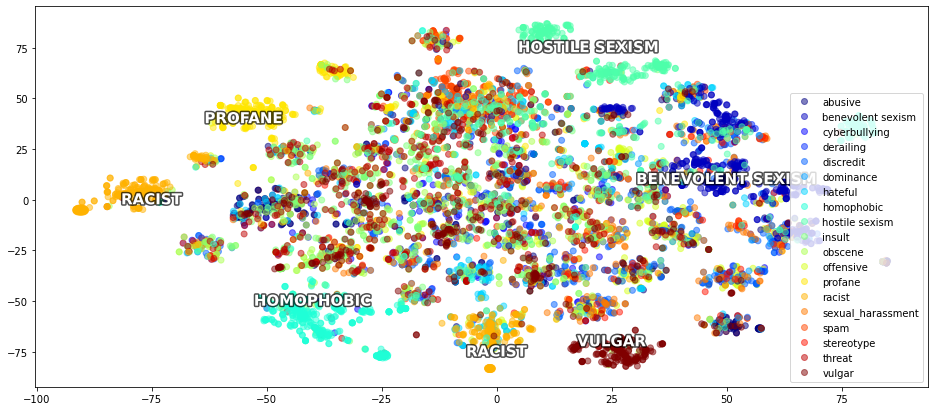

In [158]:
ax,f = plot_tsne(tfidf_mat, catCodes, np.unique(categories), np.unique(categories) )
ax.annotate("racist".upper(), alpha=1.0, xy=(0,-75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("profane".upper(), alpha=1.0, xy=(-55,40), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("homophobic".upper(), alpha=1.0, xy=(-40,-50), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("vulgar".upper(), alpha=1.0, xy=(25,-70), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("benevolent sexism".upper(), alpha=1.0, xy=(50,10), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("hostile sexism".upper(), alpha=1.0, xy=(20,75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("racist".upper(), alpha=1.0, xy=(-75,0), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])

f.show()

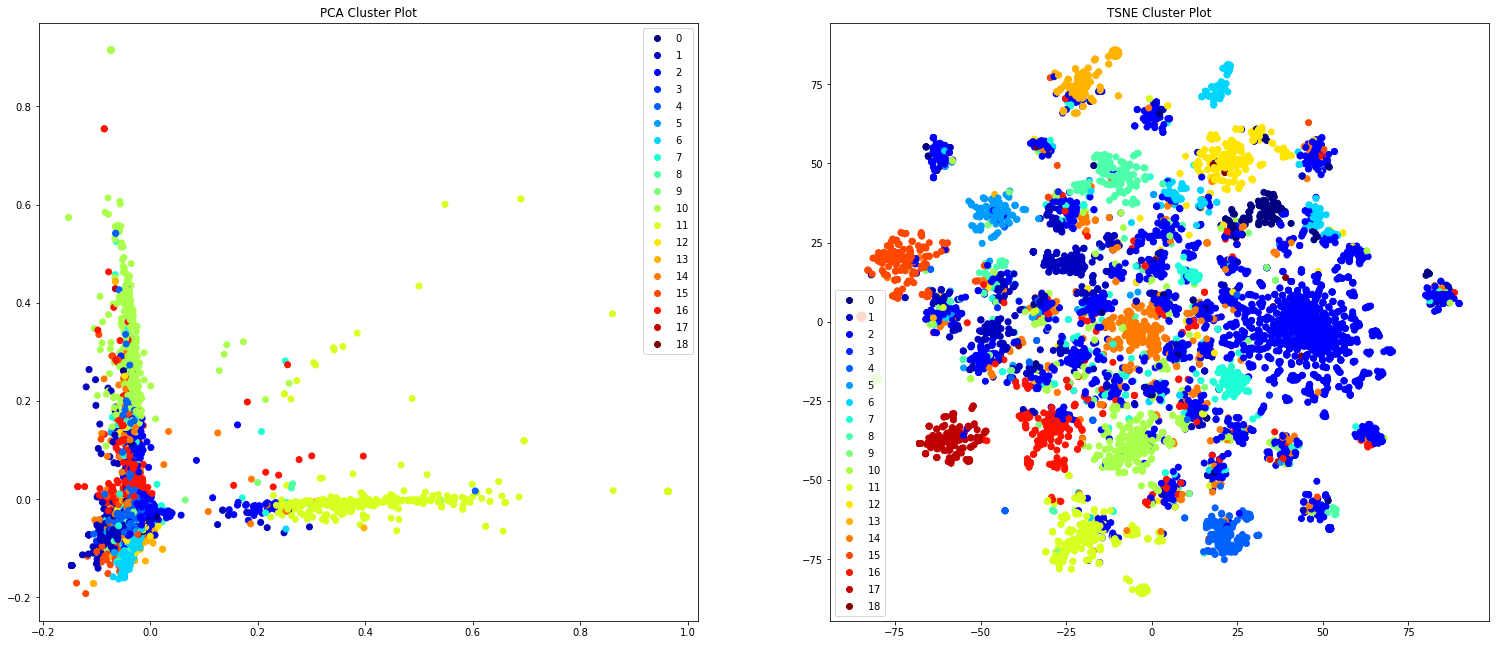

In [14]:
plot_tsne_pca(tfidf_mat, clusters)

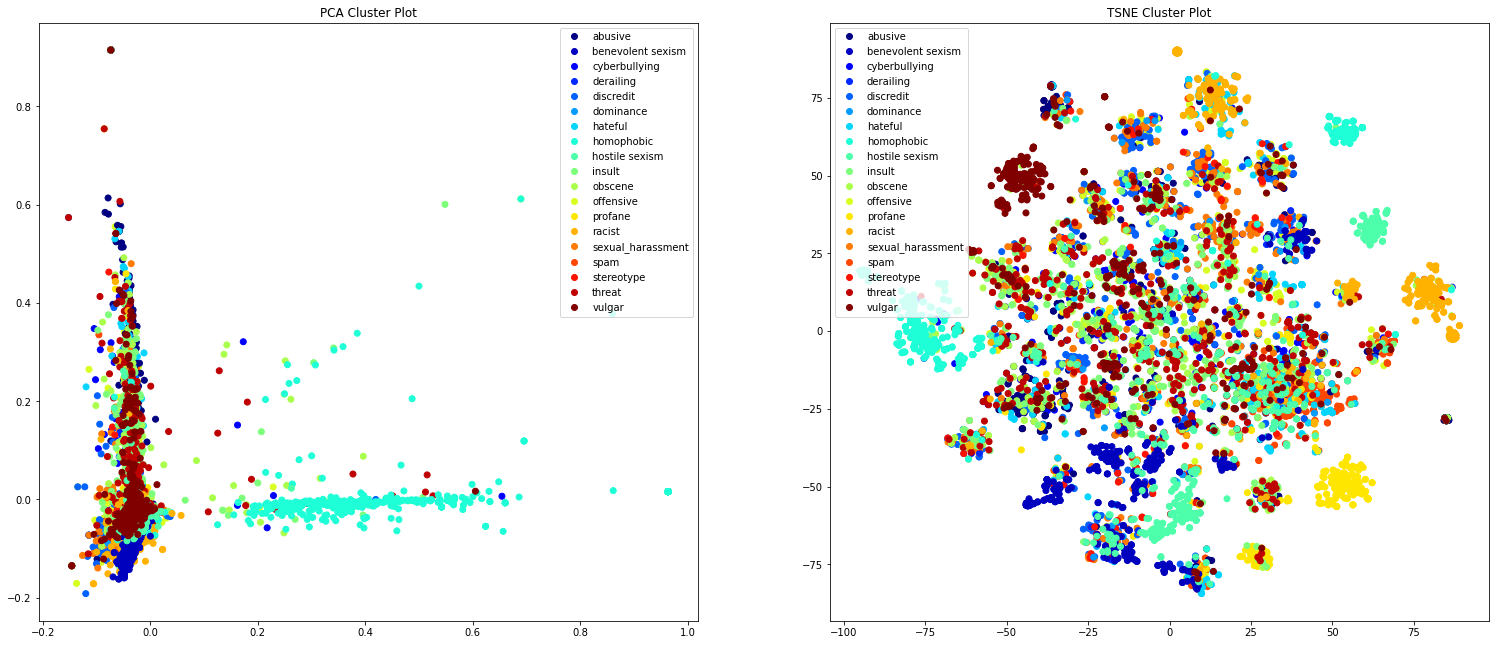

In [15]:
plot_tsne_pca(tfidf_mat, catCodes, np.unique(categories))

In [16]:
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), 15)


Cluster 0
sexist,call,girls,female,football,womens,mkr,dont,funny,sports,woman,dyke,shave,really,like

Cluster 1
bitch,ass,dick,stupid,like,get,pussy,hoe,got,shit,suck,ya,youre,aint,fuck

Cluster 2
like,fucked,dyke,get,shit,one,ass,amp,dickhead,go,youre,new,pussy,idiot,people

Cluster 3
dog,fucking,fuck,actually,get,bitches,bitch,got,go,look,shit,going,cold,something,url

Cluster 4
user,url,hell,shit,ass,damn,bitch,fucking,fuck,like,pissed,asshole,nigga,oh,one

Cluster 5
bitches,hate,like,shit,dick,bitch,ass,dont,cause,know,niggas,hoes,yall,got,fuck

Cluster 6
woman,love,man,like,good,lucky,without,last,first,womensday,luckier,loving,every,awaken,intention

Cluster 7
stop,whore,fucking,like,get,shit,please,bitch,life,stupid,go,one,wikipedia,fuck,trying

Cluster 8
girl,hoe,bitch,like,tall,dick,boy,know,rape,one,fucked,guy,good,got,smart

Cluster 9
fuckin,ass,bitch,fuck,stupid,shit,like,youre,faggot,sick,lil,got,retard,want,aint

Cluster 10
fucking,hate,shit,like,know,youre,go,cant,bitc

In [19]:
get_top_keywords(tfidf_mat, catCodes, tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster abusive
fucking,fucked,bad,ass,like,cant,dont,hate,idiot,fuck

Cluster benevolent sexism
man,woman,love,womensday,like,women,girl,good,without,adaywithoutwomen

Cluster cyberbullying
bra,get,know,bitch,dont,fake,like,fuck,shit,lol

Cluster derailing
women,rape,woman,men,lol,bitch,whore,dick,dress,dont

Cluster discredit
bitch,stupid,whore,hoe,girl,slut,women,like,ass,pussy

Cluster dominance
bitch,women,like,whore,men,yesallmen,girl,cock,dick,shut

Cluster hateful
niggas,hate,nigga,fucking,idiot,like,mad,dont,people,amp

Cluster homophobic
faggot,dyke,see,look,like,called,gay,straight,sissy,big

Cluster hostile sexism
sexist,mkr,women,kat,notsexist,girls,female,dont,call,men

Cluster insult
fuck,fucking,go,wikipedia,shit,dont,youre,page,like,get

Cluster obscene
fuck,fucking,dont,go,suck,get,shit,page,wikipedia,asshole

Cluster offensive
bitch,bitches,hoes,pussy,8220,hoe,like,fuck,aint,got

Cluster profane
fucktrump,dickhead,douchebag,trump,fuck,trumpisatraitor,resist,fucking,

Some clusters are clearly distinct and match some categories: eg. cluster 1 and benevolent sexism, cluster 4 and homophobic, cluster 13 and profane

In [20]:
homogeneity_score(clusters, catCodes)

0.32347528014712196

## Grouping documents by category & using TFIDF and word2vec embeddings

In [103]:
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))
uniquecategories = np.array(["sexism" if c == "benevolent sexism" else "hostile" if c == 'hostile sexism' else "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])

In [77]:
tfidf_vec3 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=3, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [78]:
tfidf_mat3 = tfidf_vec3.fit_transform(tweetsByCategory)
tfidf_mat3.shape

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(19, 3343)

In [79]:
documentVectors = tfidf_mat3.todense()
#documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=1).flatten()

In [80]:
similarities = documentVectors.dot(documentVectors.T)

In [82]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


In [84]:
ixs = np.argsort(ap.labels_)
ixs

array([ 1,  2,  3,  4,  5,  8, 16, 11, 14,  0,  6, 15, 12, 13,  7,  9, 17,
       10, 18], dtype=int64)

In [85]:
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

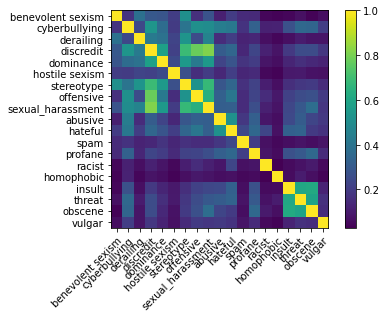

In [86]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap)
plt.show()

### Word2vec average document representations

In [87]:
import gensim.downloader as api

In [88]:
word2vec = api.load('word2vec-google-news-300')

In [89]:
documentVectors = np.zeros((300,19))
npFeatures = np.array(tfidf_vec3.get_feature_names())
for i in range(19):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30]
    print(uniquecategories[i], npFeatures[indices])
    for ix in indices:
        if npFeatures[ix] in word2vec:
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

abusive ['fucking' 'fucked' 'ass' 'like' 'bad' 'bitch' 'dont' 'fuck' 'idiot'
 'shit' 'idiots' 'want' 'get' 'know' 'hate' 'cant' 'people' 'go' 'bitches'
 '128514128514' 'yall' 'ugly' 'say' 'even' 'stop' 'thats' 'george'
 'stupid' 'need' 'damn']
benevolent sexism ['woman' 'man' 'love' 'like' 'women' 'girl' 'good' 'amp' 'lucky' 'without'
 'happy' 'intention' 'loving' 'every' 'first' 'last' 'strong' 'day'
 'coward' 'world' 'men' 'think' 'beautiful' 'act' 'girls' 'wife' 'life'
 'would' 'biggest' 'mother']
cyberbullying ['fake' 'bra' 'bitch' 'r' 'dont' 'like' 'fucking' 'get' 'fuck' 'shit'
 'know' 'ass' 'stop' 'ugly' 'go' 'life' 'ur' 'haha' 'okay' 'say' 'lol'
 'hoe' 'stupid' 'face' 'one' 'suck' 'would' 'anonymous' 'people' 'pretty']
derailing ['women' 'woman' 'rape' 'bitch' 'forward' 'dont' 'men' 'dumbass' 'sexism'
 'assault' 'dick' 'come' 'birth' 'yesallmen' 'whore' 'like' 'pregnant'
 'sexual' 'lol' 'dress' 'control' 'hole' 'girl' 'every' 'want' 'get'
 'understand' 'asked' 'sign' 'cuz']
disc

In [90]:
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0)

In [91]:
similarities = documentVectors.T.dot(documentVectors)

In [104]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


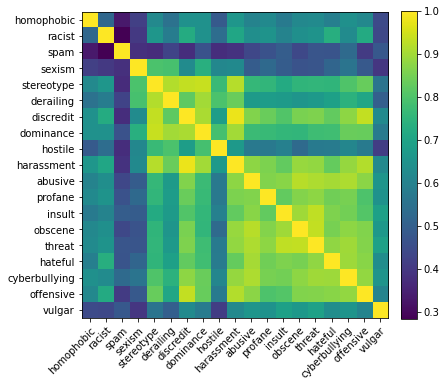

In [108]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(6, 6)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()